# Reef Life Survey (RLS) data download and STAARS climatology comparaison

This is a demo example to retrieve data from the [Reef Life Survew](https://reeflifesurvey.com/) Project [Geoserver](http://geoserver.org/) WMS/WFS layers. The data will then be compared to a climatology gridded dataset available on the [IMOS S3 bucket](data.aodn.org.au)

## 1 RLS data download via Geoserver

### 1.1 Geoserver (IMAS) overview
In this section, we're using the IMAS geoserver to find the RLS dataset.

In [1]:
#!/usr/bin/env python3
from owslib.etree import etree
from owslib.fes import BBox, PropertyIsLike
from owslib.wfs import WebFeatureService
from owslib.wms import WebMapService
import os
import xml.etree.ElementTree as ET

GEOSERVER_URL = 'http://geoserver.imas.utas.edu.au/geoserver/'
GEOSERVER_WMS_LAYER = '{geoserver_url}/wms'.format(geoserver_url=GEOSERVER_URL)
GEOSERVER_WFS_LAYER = '{geoserver_url}/wfs'.format(geoserver_url=GEOSERVER_URL)

In [2]:
wms = WebMapService(GEOSERVER_WFS_LAYER, version='1.1.1')
wms.identification.title

'IMAS Web Mapping Service (WMS)'

In [3]:
wms_wfs_ls = list(wms.contents)  # list containing ALL IMAS geoserver layers

rls_collection_to_search_str = "RLS_REEF_FISH"
matching = [s for s in wms_wfs_ls if rls_collection_to_search_str.lower() in s.lower()]
print(matching)

# we get a *_DATA (WFS) and a *_MAP (WMS layer)

['rls:RLS_REEF_FISH_DATA', 'rls:RLS_REEF_FISH_MAP']


### 1.2 Visualisation of the Reef Life Survey fish location around Tasmania
_The Open Geospatial Consortium has defined several Open Web Services for accessing (usually geographic) data. There are two basic service sets – the Web Feature Services (WFS) and the Web Map Services (WMS). The WFS is concerned with direct access to your data – reading, writing, and updating your features. The WMS is concerned with transforming your data into a map (image)._ [Ref](http://blog.geoserver.org/2006/11/27/the-wfs-and-wms-services/)

In this section, we look for the data available around Tasmania by using the WMS layer. The data will then be plotted.

In [4]:
# WMS and WFS layers definition
layer1_wms_name = 'rls:RLS_REEF_FISH_MAP'
layer1_wfs_name = 'rls:RLS_REEF_FISH_DATA'

/home/lbesnard/anaconda3/lib/python3.7/site-packages/cartopy/io/img_tiles.py:320: UserWarning: The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.
  "The StamenTerrain class was deprecated in v0.17. "


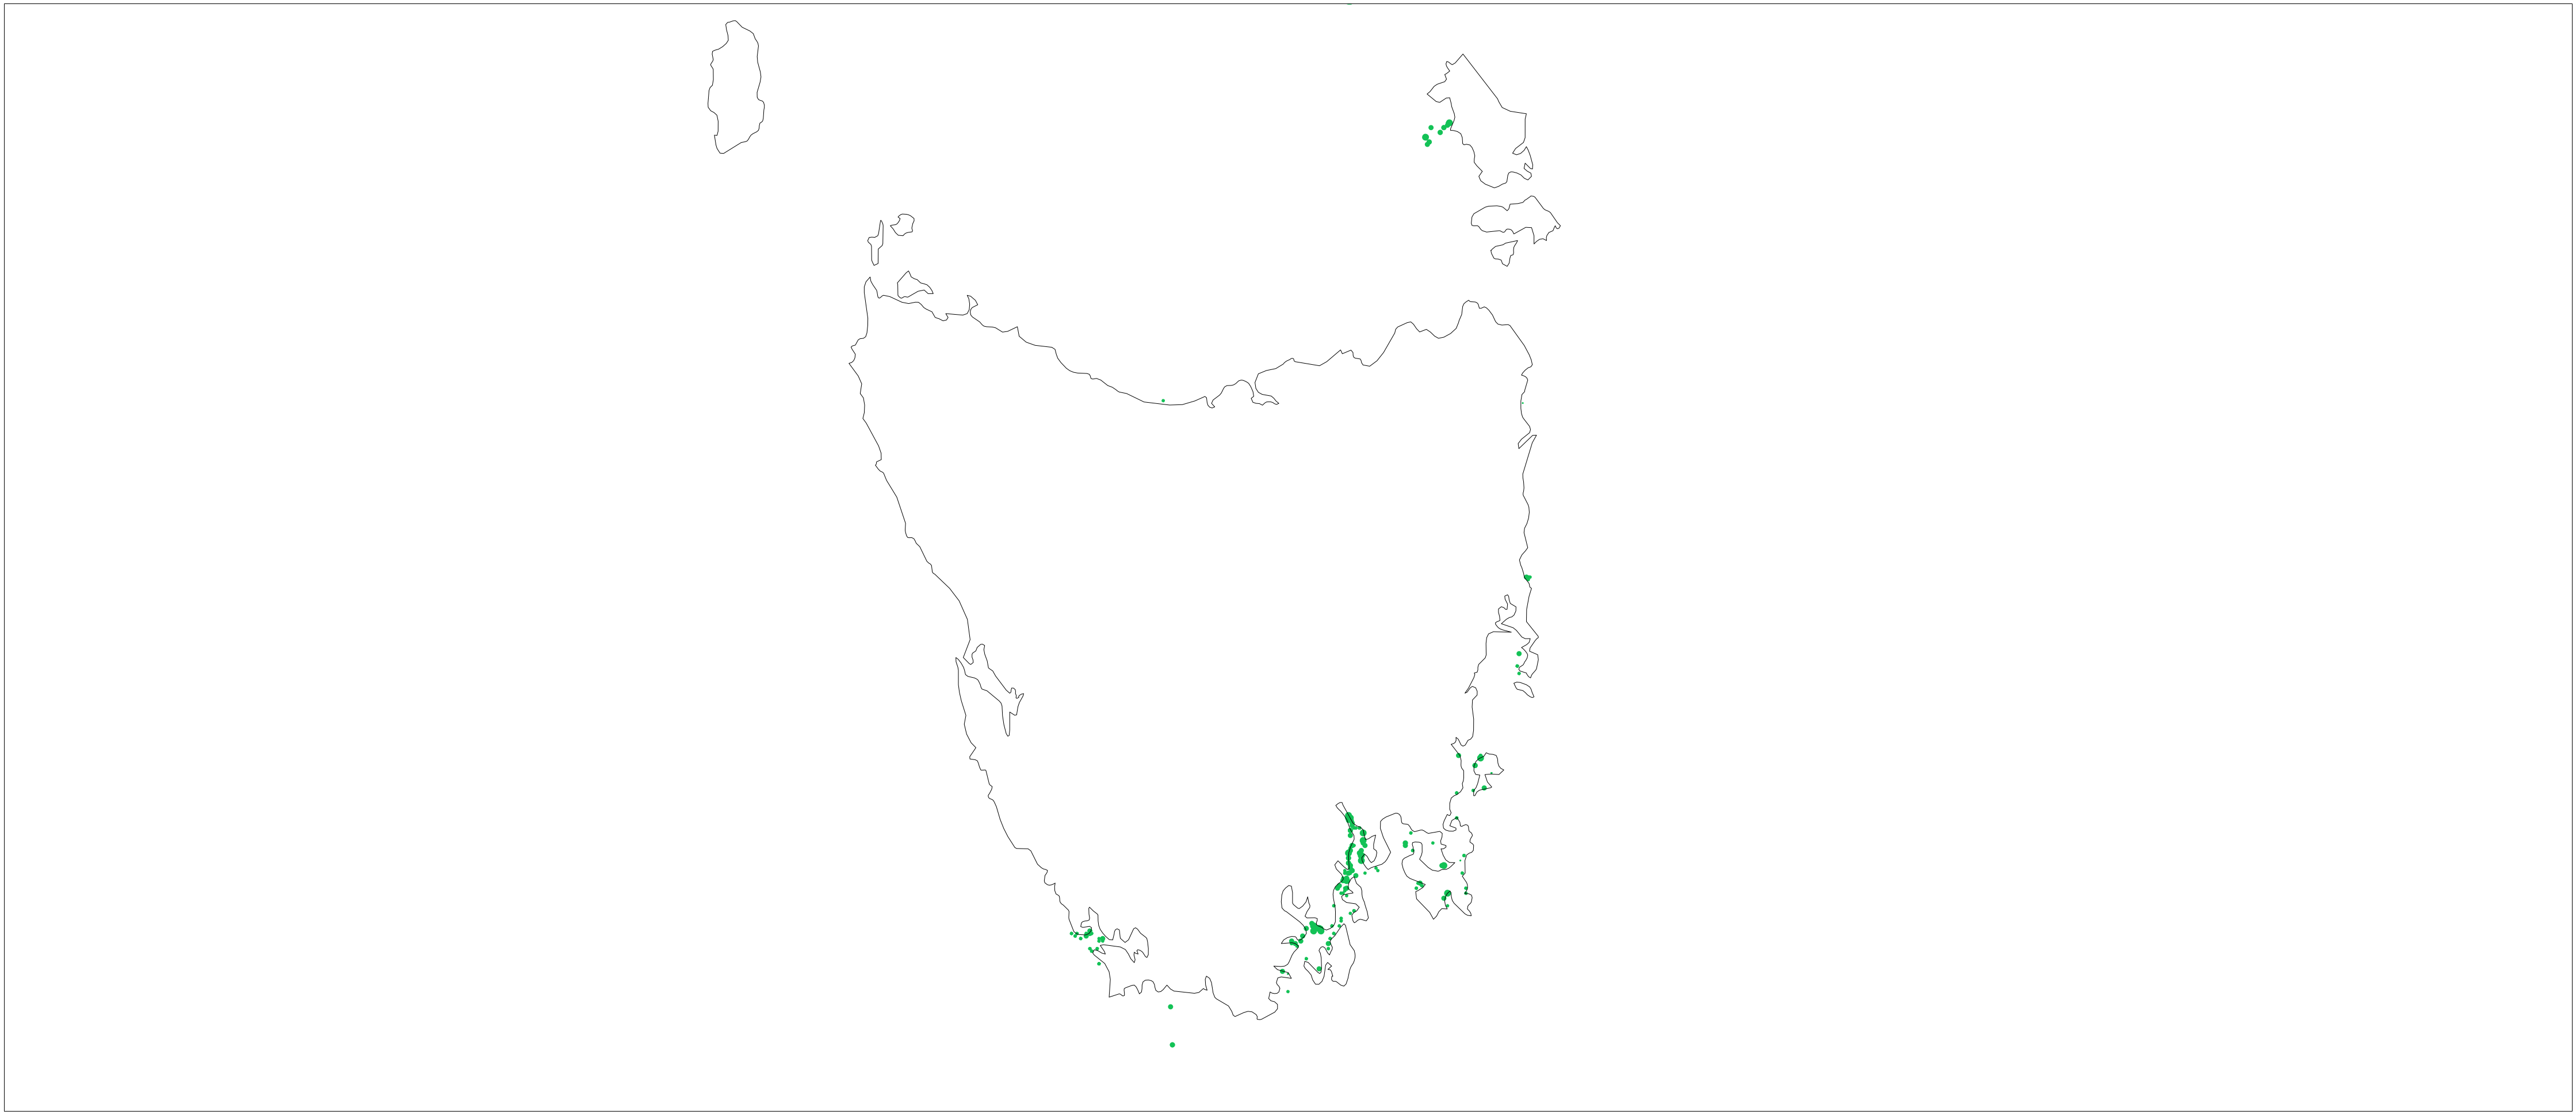

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from cartopy.io.img_tiles import StamenTerrain

lon_min = 140
lon_max = 154
lat_min = -44
lat_max = -39.5
bounding_box_wms = [lon_min, lon_max, lat_min, lat_max]  # [lon_min, lon_max, lat_min, lat_max]


tiler = StamenTerrain()
fig = plt.figure(figsize=(80, 70))
mercator = tiler.crs
ax = fig.add_subplot(1, 1, 1, projection=mercator)
ax.set_extent(bounding_box_wms, crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=1)

# plot the geoserver layer
ax.add_wms(wms=GEOSERVER_WMS_LAYER,
           layers=layer1_wms_name)


plt.show()

### 1.3 Rerieve the associated data via the WFS layer
In order to get the asssociated data, the WFS layer has to be queried, using the bounding box defined above

In [7]:
import json

wfs = WebFeatureService(url=GEOSERVER_WFS_LAYER, version='1.1.0', timeout=30)
rls_data = wfs[layer1_wfs_name]

# retrieve WFS data with a bbox filter defined above
response = wfs.getfeature(typename=layer1_wfs_name, 
                          bbox=(lon_min, lat_min, lon_max, lat_max), 
                          srsname='EPSG:4326',  # Spatial Reference
                          outputFormat='application/json')

res = response.read()
json_output = json.dumps(json.loads(res))
data = json.loads(json_output)

### 1.4 Using Pandas dataframe

Once downloaded from Geoserver as a JSON file format, loading the data into Pandas allows us to filter it easily.

In [8]:
from pandas.io.json import json_normalize
df_rls_data = json_normalize(data['features'])
df_rls_data.head() # only displaying the first few rows

,geometry.coordinates,geometry.type,geometry_name,id,properties.Block,properties.Country,properties.Depth,properties.Diver,properties.Ecoregion,properties.Family,properties.Realm,properties.Site,properties.SiteCode,properties.SiteLat,properties.SiteLong,properties.SurveyDate,properties.SurveyID,properties.Taxon,properties.Total,type
0,"[146.36, -43.59]",Point,geom,RLS_REEF_FISH_DATA.126615,1,Australia,10.0,IVS,Bassian,Dinolestidae,Temperate Australasia,De Witt Island,TAS92,-43.59,146.36,2013-03-02T13:00:00Z,912342703,Dinolestes lewini,70,Feature
1,"[147.88, -40]",Point,geom,RLS_REEF_FISH_DATA.84497,2,Australia,9.0,RSS,Cape Howe,Monacanthidae,Temperate Australasia,Port Davies,TAS77,-40.00,147.88,2008-01-28T13:00:00Z,7000572,Meuschenia flavolineata,4,Feature
2,"[148.3, -41.87]",Point,geom,RLS_REEF_FISH_DATA.86418,2,Australia,7.0,GJE,Bassian,Labridae,Temperate Australasia,Waubs Bay,TAS66,-41.87,148.30,2008-05-02T14:00:00Z,7000609,Dotalabrus aurantiacus,3,Feature
3,"[147.76, -40.09]",Point,geom,RLS_REEF_FISH_DATA.86489,2,Australia,5.0,GJE,Cape Howe,Cheilodactylidae,Temperate Australasia,SE Prime Seal,TAS69,-40.09,147.76,2008-01-27T13:00:00Z,7000568,Cheilodactylus nigripes,2,Feature
4,"[148.26, -42.26]",Point,geom,RLS_REEF_FISH_DATA.126544,2,Australia,4.9,PBD,Bassian,Labridae,Temperate Australasia,Bryans,TAS87,-42.26,148.26,2011-01-14T13:00:00Z,7002851,Notolabrus tetricus,12,Feature


### 1.5 Example: Find unique fish families spoted in Port Davies (NE Tasmania)
In this section, we demonstrate how to look for a certain type of fish family found in a certain area. The different filters available (such as ```'properties.Site'```) are basically the column names, or header of the panda dataframe (```df_rls``` here)

In [9]:
site_list = df_rls_data['properties.Site'].unique()
df_rls_data[df_rls_data['properties.Site'] == 'Port Davies' ]['properties.Family'].unique()

array(['Monacanthidae', 'Plesiopidae', 'Diodontidae', 'Pentacerotidae',
       'Odacidae', 'Serranidae', 'Kyphosidae', 'Pempheridae', 'Labridae',
       'Pomacentridae', 'Cheilodactylidae', 'Enoplosidae', 'Mullidae'],
      dtype=object)

In [10]:
df_rls_data[(df_rls_data['properties.Site'] == 'Port Davies') &  
            (df_rls_data['properties.Family'] == 'Kyphosidae')][
    ['geometry.coordinates', 'properties.SurveyDate']
]

,geometry.coordinates,properties.SurveyDate
794,"[147.88, -40]",2008-01-28T13:00:00Z
1032,"[147.88, -40]",2008-01-28T13:00:00Z
2444,"[147.88, -40]",2008-01-28T13:00:00Z
3162,"[147.88, -40]",2008-01-28T13:00:00Z


### 1.6 Export data to CSV
Exporting the filtered or un-filtered data as a CSV file is extremely easy: 

In [11]:
df_rls_data.to_csv(path_or_buf='/tmp/data.csv', index=False)

### 1.7 Alternative Example
In this example, instead of looking for all species in a specific region, we're looking for a certain type of fish (Arctocephalus pusillus) across the entire Reef Life Survey dataset

#### 1.7.1 Retrieve the data

In [12]:
## string property
filename_wfs_filter ='Arctocephalus pusillus'
column = 'Taxon' 
filter_1 = PropertyIsLike(propertyname=column, literal=filename_wfs_filter, wildCard='%')

filters_xml = etree.tostring(filter_1.toXML()).decode("utf-8")

response = wfs.getfeature(typename=layer1_wfs_name, filter=filters_xml, outputFormat='application/json')
res = response.read()

json_output = json.dumps(json.loads(res))
data = json.loads(json_output)
rls_filter_taxon_data = json_normalize(data['features'])

rls_filter_taxon_data.head()

,geometry.coordinates,geometry.type,geometry_name,id,properties.Block,properties.Country,properties.Depth,properties.Diver,properties.Ecoregion,properties.Family,properties.Realm,properties.Site,properties.SiteCode,properties.SiteLat,properties.SiteLong,properties.SurveyDate,properties.SurveyID,properties.Taxon,properties.Total,type
0,"[148.79, -37.82]",Point,geom,RLS_REEF_FISH_DATA.11157,2,Australia,14.0,AJW,Cape Howe,Otariidae,Temperate Australasia,Seal Gully,BR13,-37.82,148.79,2012-08-21T14:00:00Z,912341923,Arctocephalus pusillus,3,Feature
1,"[148.79, -37.82]",Point,geom,RLS_REEF_FISH_DATA.11164,1,Australia,14.0,DTL,Cape Howe,Otariidae,Temperate Australasia,Seal Gully,BR13,-37.82,148.79,2012-08-21T14:00:00Z,912341923,Arctocephalus pusillus,4,Feature
2,"[149.98, -37.51]",Point,geom,RLS_REEF_FISH_DATA.21439,1,Australia,8.3,DTL,Cape Howe,Otariidae,Temperate Australasia,Howe Central,CHMP-S5,-37.51,149.98,2011-02-03T13:00:00Z,3002553,Arctocephalus pusillus,1,Feature
3,"[150.81, -35.09]",Point,geom,RLS_REEF_FISH_DATA.35047,1,Australia,13.0,JRA,Cape Howe,Otariidae,Temperate Australasia,Seal Colony,JBMP47,-35.09,150.81,2008-07-06T14:00:00Z,2000862,Arctocephalus pusillus,2,Feature
4,"[150.81, -35.09]",Point,geom,RLS_REEF_FISH_DATA.35065,2,Australia,13.0,STN,Cape Howe,Otariidae,Temperate Australasia,Seal Colony,JBMP47,-35.09,150.81,2008-07-06T14:00:00Z,2000862,Arctocephalus pusillus,1,Feature


#### 1.7.2 Plot the location of Arctocephalus pusillus

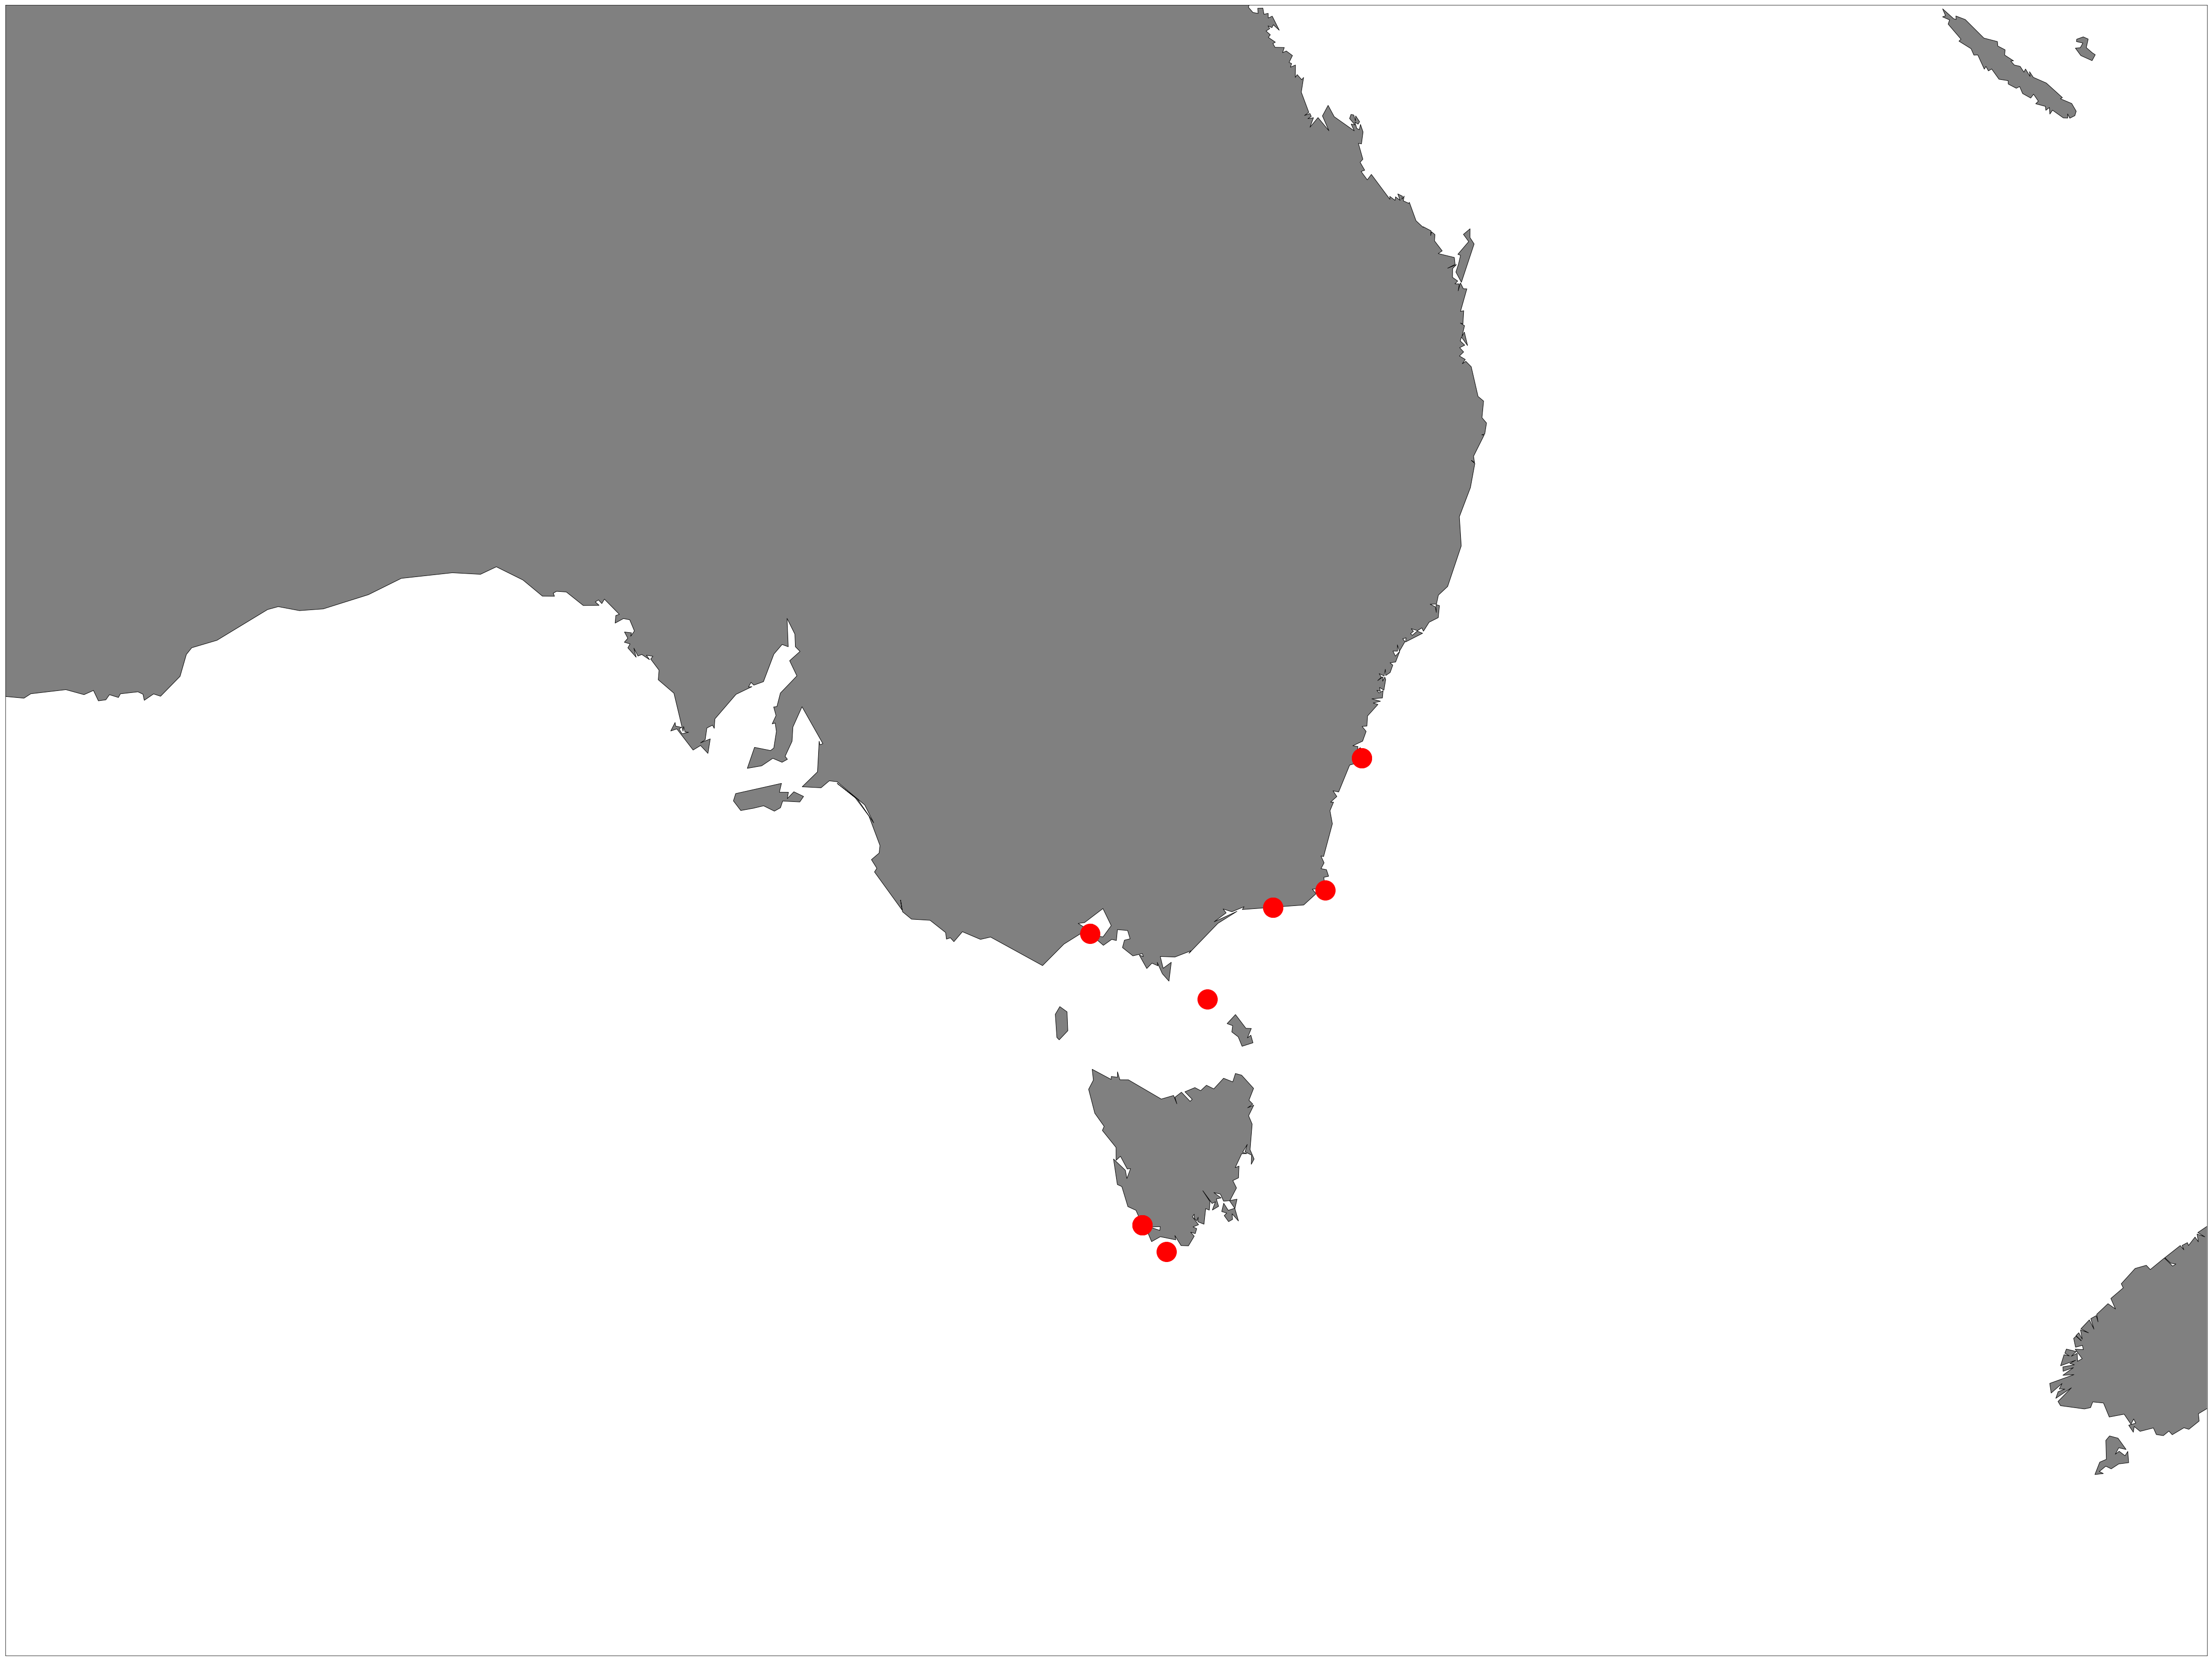

In [26]:
from mpl_toolkits.basemap import Basemap
import numpy as np

bounding_box_wms = [120, 170, -50, -20]  # [lon_min, lon_max, lat_min, lat_max]

lats = np.stack(rls_filter_taxon_data['geometry.coordinates'].values)[:,1]
lons = np.stack(rls_filter_taxon_data['geometry.coordinates'].values)[:,0]

plt.figure(figsize=(80, 120))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bounding_box_wms[2],urcrnrlat=bounding_box_wms[3],\
            llcrnrlon=bounding_box_wms[0],urcrnrlon=bounding_box_wms[1],resolution='l')
 
# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='grey')

# build and plot coordinates onto map
x,y = m(lons,lats)
m.plot(x,y,'rx', markersize=40, marker='o')

plt.show()

## 2. Visualisation of SSTAARS climatology accessed through AODN S3 repository

### Three ways to access AODN data:
* 1. AODN portal: https://portal.aodn.org.au/
* 2. THREDDS server :  http://thredds.aodn.org.au/thredds/catalog.html
   * SSTAARS example : http://thredds.aodn.org.au/thredds/catalog/CSIRO/Climatology/SSTAARS/2017/AODN-product/catalog.html
   * OPENDAP: /thredds/__dodsC__/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_001.nc
   * HTTPServer: /thredds/__fileServer__/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_001.nc
* 3. Amazon Web Services (AWS) s3 bucket - object oriented repository:  
   * Explore s3 bucket : https://data.aodn.org.au   
   * S3 bucket name: imos-data
   * Download from AWS s3 server https://help.aodn.org.au/downloading-data-from-servers/amazon-s3-servers/
   * Accessing/ Downloading using python s3fs library (this notebook)


### Accessing without downloading:
In python, you can access the AODN files using OPENDAP or s3fs library.  The s3 bucket is the AODN original depository. To provide DAP access to the file, AODN developed some functions to retrieve (and cache) data files from S3. It is more direct to access the data through S3 directly. 

### 2.1 Accessing and opening the s3 file


In [30]:
#libraries
import xarray as xar
import dask
import s3fs

#s3 FileSystem 
s3 = s3fs.S3FileSystem(anon = True)

# imos bucket on AWS is named 'imos-data'
# list directories using s3.ls
s3.ls('imos-data') # imos bucket name

# list directories and files using 
s3.ls('imos-data/CSIRO/Climatology/SSTAARS/2017')

['imos-data/CSIRO/Climatology/SSTAARS/2017/SSTAARS.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product']

In [31]:
# original product SSTRAARS.nc (with harmonics) and AODN-product with daily fit already calculated
# SSTAARS climatology : listing directories and daily files
s3.ls('imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product')[0:10]

['imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_001.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_002.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_003.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_004.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_005.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_006.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_007.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_008.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_009.nc']

In [32]:
# Opening a daily climatology from AODN-product:
# # 28th of January is day 28
# we can directly open a netcdf file using the s3 location
file = 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_028.nc'

# But unfortunatly the following does not work because of an attribute read error with NetCDF4 files, 
# so we will download the file locally
#ds = xar.open_mfdataset(file)

### Downloading the netcdf from s3 bucket


In [33]:
import tempfile
temp_file = tempfile.mkstemp()
temp_file_path = temp_file[1]

# download command : s3.get (s3_file, local_file)
s3.get(file, temp_file_path)

### 2.2 Opening the local file with xarray

In [34]:
# opening the local file with xarray as a dataset
# we need option decode_times=False because this is a climatology with no calendar date associated with it
ds = xar.open_dataset(temp_file_path, decode_times=False)

# exploring the xarray dataset
ds

<xarray.Dataset>
Dimensions:             (DAY_OF_YEAR: 1, LATITUDE: 4500, LONGITUDE: 6000)
Coordinates:
  * DAY_OF_YEAR         (DAY_OF_YEAR) int16 28
  * LATITUDE            (LATITUDE) float32 -69.99 -69.97 -69.95 ... 19.97 19.99
  * LONGITUDE           (LONGITUDE) float32 70.01 70.03 70.05 ... 189.97 189.99
    DEPTH               float32 ...
Data variables:
    TEMP                (DAY_OF_YEAR, LATITUDE, LONGITUDE) float32 ...
    TEMP_std_err        (DAY_OF_YEAR, LATITUDE, LONGITUDE) float32 ...
    TEMP_mean           (LATITUDE, LONGITUDE) float32 ...
    TEMP_mean_std_err   (LATITUDE, LONGITUDE) float32 ...
    TEMP_trend          (LATITUDE, LONGITUDE) float32 ...
    TEMP_trend_std_err  (LATITUDE, LONGITUDE) float32 ...
Attributes:
    abstract:                      25 years of Advanced Very High-Resolution ...
    acknowledgement:               The User agrees that whenever the Product ...
    author:                        Galibert, Guillaume
    author_email:                 

### 2.3 Extracting arrays from the ds dataset for the region of interest:

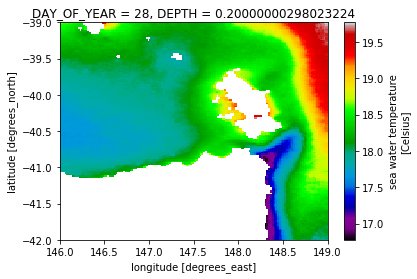

In [35]:
## Coordinates values found from WFS [147.88, -40] 
port_davies_lat_min = -42.0
port_davies_lat_max = -39.0
port_davies_lon_min = 146
port_davies_lon_max = 149

colormap='nipy_spectral'
cmap = plt.get_cmap(colormap) 

ds.TEMP.sel(LATITUDE=slice(port_davies_lat_min, port_davies_lat_max), 
            LONGITUDE=slice(port_davies_lon_min, port_davies_lon_max)).plot(cmap=cmap)